# Working with Word Embeddings

In this assigment will learn how to work with word embeddings, and that with simple techniques we can implement cool things.

The assignment is divided in many parts that in most of the cases do not need code implementation. Hopefully, you would complete the assignment in short time and have great fun too. 

- __Part 0__: It is for setting up every thing, like load embeddings, normalize them etc.
- __Part 1__: We will use word embeddings for finding similar and relatead words.
- __Part 2__: We will learn scoring semantically words.
- __Part 3__: We will learn doing analogies, like `man-king` and `woman-queen`
- __Part 4__: We will learn visualizing embeddings.

## Part 0: Set up

We first define some helper functions for printing results and reading embeddings.

In [0]:
def print_header(title):
    print('┌───────────────────────────────────────────────────────────────┐')
    print('│{0:^63}│'.format(title))
    print('├──────────┬─────────────────────────────┬──────────┬───────────┤')

def print_footer():
    print('└──────────┴─────────────────────────────┴──────────┴───────────┘')

def print_oov(oov):
    if len(oov) > 0:
        print('OOV: {0}'.format(', '.join(oov)))

def print_row(index, last, trg_words, knn, sim):
    if last >= index or index < 0:
        return last
    if last < index - 1:
        print('│  {0:>5}  │  {0:^25}  │  {0:>5}   │  {0:^7} │'.format('⋮'))
    word = trg_words[knn[index]]
    word = ('{0:^25}').format(word)
    print('│  {0:>6}  │  {1}  │  {2:>6}  │  {3:7.4f}  │'.format(index + 1, word, knn[index], sim[knn[index]]))
    return index

In [0]:
import numpy as np

def read(file, threshold=0, dim=50, vocabulary=None):
    count = 400000 if threshold <= 0 else min(threshold, 400000)
    words = []
    matrix = np.empty((count, dim)) if vocabulary is None else []
    for i in range(count):
        word, vec = file.readline().split(' ', 1)
        if vocabulary is None:
            words.append(word)
            matrix[i] = np.fromstring(vec, sep=' ')
        elif word in vocabulary:
            words.append(word)
            matrix.append(np.fromstring(vec, sep=' '))
    return (words, matrix) if vocabulary is None else (words, np.array(matrix))

In [0]:
def length_normalize(matrix):
    norms = np.sqrt(np.sum(matrix**2, axis=1))
    norms[norms == 0] = 1
    return matrix / norms[:, np.newaxis]

__Load data__

First let's load a set of 50D word vectors from GloVe. If you want to run local you can download them at the following [url](http://nlp.stanford.edu/data/glove.6B.zip) (1GB). The zip file includes embeddings of different dimensionality (50d, 100d, 200d, 300d) for a vocabulary of 400000 words. Decompress them and place somewhere, for example in `./embeddings/` folder

`glove_home` below specifies the location of the unzipped file. 

Variables like `matrix` and `word2ind` are used below in the notebook by different functions, so you need first load data in order to make everything work.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Read input embeddings
glove_home = 'drive/My Drive/2019-2020_labs/data/embeddings/glove.6B.50d.txt'
embsfile = open(glove_home, encoding='utf-8', errors='surrogateescape')
words, matrix = read(embsfile)

# Length normalize embeddings so their dot product effectively computes the cosine similarity
matrix = length_normalize(matrix)

# Build word to index map
word2ind = {word: i for i, word in enumerate(words)}

## Part 1: Semantically similar/related words

In [0]:
def knn(word, k=10):
    try:
        # calculate nearest (more similar)
        i = word2ind[word]
        sim = matrix[i].dot(matrix.T)
        knn = np.argsort(-sim)
    except KeyError:
        # print results
        print_header('{0} (OOV)'.format(word))
        print_footer()
        print()
        return
    print_header('{0} ({1})'.format(word, i + 1))
    last = -1
    # loop k words
    for j in range(k):
        # print them as result
        word = words[knn[j]]
        last = print_row(j, last=last, trg_words=words, knn=knn, sim=sim)
    last = print_row(len(knn)-1, last=last, trg_words=words, knn=knn, sim=sim)
    print_footer()
    print()


`knn` function retrieve the _k_ most similar/related words of the target word according to the given embedding space. The output looks like the following:

   - first column for nearest neighbour index
   - second column for nearest neighbour word
   - third column for index of word in frequency ranking (1 is most frequent)
   - last column for cosine (1 for perfect similarity)



In [0]:
# Show the 30 nearest neighbors (usage example)
knn('pound', k=30)

┌───────────────────────────────────────────────────────────────┐
│                         pound (3606)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            pound            │    3605  │   1.0000  │
│       2  │           pounds            │    1696  │   0.8113  │
│       3  │           dollar            │     678  │   0.7066  │
│       4  │           ounces            │   10573  │   0.7060  │
│       5  │            cent             │    4368  │   0.7049  │
│       6  │          kilogram           │   19141  │   0.6869  │
│       7  │            ounce            │    6215  │   0.6850  │
│       8  │             ton             │    8811  │   0.6791  │
│       9  │           barrel            │    3401  │   0.6744  │
│      10  │            kilo             │   27447  │   0.6675  │
│      11  │            pork             │    7635  │   0.6660  │
│      12  │             cut             │     611  │   0.6609  │
│      13 

### TODO1: 
Check the results for the words below. List which words you think are working well, and which ones it is failing.

- france, jesus, xbox, reddish, scratched, megabits 

Try any other word you fancy, and write any comment you might have. Keep a copy of the output including 30 nearest neighbours.

In [0]:
# Show the 30 nearest neighbors
knn('france', k=30)

┌───────────────────────────────────────────────────────────────┐
│                         france (388)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           france            │     387  │   1.0000  │
│       2  │           french            │     348  │   0.8868  │
│       3  │           belgium           │    2975  │   0.8632  │
│       4  │            paris            │    1035  │   0.8025  │
│       5  │            spain            │    1029  │   0.7909  │
│       6  │         netherlands         │    2238  │   0.7894  │
│       7  │            italy            │     931  │   0.7789  │
│       8  │           germany           │     509  │   0.7745  │
│       9  │          european           │     291  │   0.7627  │
│      10  │         switzerland         │    2311  │   0.7578  │
│      11  │           europe            │     525  │   0.7540  │
│      12  │           belgian           │    4072  │   0.7460  │
│      13 

This list of neighbors works well. We can see that most of the words listed are either other countries in Europe close to France, or cities which are either in France or in sorrounding countries. There are also some denomyms such as "european", "french", "spanish", or "belgian". In other words here are all names of countries and cities, some of them neightbouring, and nationalities.

There is also something worth pointing out, which is the fact that we can see the word "France" itself listed as the most similar word. This is expected as the most similar word is always going to be the word itself and we have not programmed it to exclude the word in the query. This is something that happens recurrent in all lists in this exercise.

In [0]:
# Show the 30 nearest neighbors
knn('jesus', k=30)

┌───────────────────────────────────────────────────────────────┐
│                         jesus (3994)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            jesus            │    3993  │   1.0000  │
│       2  │           christ            │    4904  │   0.8533  │
│       3  │             god             │    1533  │   0.7633  │
│       4  │        resurrection         │   16493  │   0.7583  │
│       5  │         crucifixion         │   27882  │   0.7296  │
│       6  │           divine            │    8661  │   0.7133  │
│       7  │           blessed           │   10141  │   0.6988  │
│       8  │           priest            │    4314  │   0.6939  │
│       9  │            holy             │    2677  │   0.6904  │
│      10  │            faith            │    2714  │   0.6879  │
│      11  │          disciples          │   18225  │   0.6819  │
│      12  │           sacred            │    6404  │   0.6781  │
│      13 

This is working very well as well. All the words listed as most similar to "jesus" are related to religion, as expected. More specifically, they are mostly related to christianity, probably because those texts where the word "jesus" is used are probably specific enough to be talking about chirstianity in particular rather than about religion in general.

although some words that we would expect to see here are missing, such as the Bible, Christianity or other words related to jesus: Jewish, Judaism, Nazareth, son, leader, etc.

In [0]:
# Show the 30 nearest neighbors
knn('xbox', k=30)

┌───────────────────────────────────────────────────────────────┐
│                         xbox (12812)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            xbox             │   12811  │   1.0000  │
│       2  │         playstation         │   10498  │   0.9490  │
│       3  │             ps2             │   49520  │   0.8948  │
│       4  │             ps3             │   40478  │   0.8918  │
│       5  │          nintendo           │    9778  │   0.8916  │
│       6  │           console           │   11125  │   0.8815  │
│       7  │          gamecube           │   39638  │   0.8753  │
│       8  │          consoles           │   19550  │   0.8698  │
│       9  │          dreamcast          │   39767  │   0.8659  │
│      10  │             wii             │   16452  │   0.8364  │
│      11  │             psp             │   35248  │   0.8011  │
│      12  │             ds              │   19150  │   0.7966  │
│      13 

Similarly to what we have encountered in the previous two lists, this list depicts different console brands such as "Playstation", "Wii", or "Dreamcast" and words related to videogames such as "console" and "videogame", as well as technology and devices in general such as "iPad", "iPhone", or "app". There are no words here which we could consider out of context. 

In [0]:
# Show the 30 nearest neighbors
knn('reddish', k=30)

┌───────────────────────────────────────────────────────────────┐
│                        reddish (24228)                        │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           reddish           │   24227  │   1.0000  │
│       2  │          yellowish          │   31415  │   0.9405  │
│       3  │           pinkish           │   55952  │   0.9055  │
│       4  │          greenish           │   39602  │   0.8990  │
│       5  │           grayish           │   60286  │   0.8976  │
│       6  │           mottled           │   48874  │   0.8832  │
│       7  │          purplish           │   60041  │   0.8797  │
│       8  │          brownish           │   34620  │   0.8794  │
│       9  │           bluish            │   50275  │   0.8793  │
│      10  │           whitish           │   37132  │   0.8692  │
│      11  │        reddish-brown        │   68131  │   0.8682  │
│      12  │          red-brown          │   98485  │   0.8191  │
│      13 

This is a very interesting list. As before, this is working properly. They all are colors or words related to colors. At first, it might look surprising not to see "red" or "slightly red" in this list, which are tokens that would be used synonymously with "reddish". Instead, the words listed are used in a semantic similar way. They are all colors that approximate basic colors such as "red", "white", or "orange" but are not a basic color themselves. Additionally, some of them are morphologically close as well (attaching the preffix -ish" to the basic color) and of the same word class (adjectives), but others are nor morphologycally close (e.g. "silvery" or "compery"), and others are just combinations of basic colors such as "yellow-green" or "grey-brown" which again depict a color that approximates a basic color (or two in this case) but are not a basic color themselves, just similar. We also have some comparative adjectives related to colors such as "darker" or "paler". It is interesting to see that rather than just listing colors in general, the model has been able to go a bit further and look for colors that are similar to basic colors or describe features of colors. The only exception is "purple" which has been added to the list as well.

In addition The words are grouped apparently based on their morphology,as we introduced, there are different colors ending with -ish, rather than their semantics, although it also picks some red-related words. Instead of giving other colors similar to reddish, such as slightly red or ringed red, it gives other words of colors with the same suffix.

In [0]:
# Show the 30 nearest neighbors
knn('scratched', k=30)

┌───────────────────────────────────────────────────────────────┐
│                       scratched (21526)                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          scratched          │   21525  │   1.0000  │
│       2  │          blistered          │   61508  │   0.7427  │
│       3  │        inexplicably         │   28658  │   0.7210  │
│       4  │           punched           │   14019  │   0.7095  │
│       5  │           popped            │   15366  │   0.7019  │
│       6  │            sore             │   10255  │   0.7017  │
│       7  │           bruised           │   14726  │   0.7013  │
│       8  │           bashed            │   46651  │   0.6841  │
│       9  │           bruise            │   33626  │   0.6792  │
│      10  │          bothered           │   12503  │   0.6767  │
│      11  │           nicked            │   55977  │   0.6756  │
│      12  │            legs             │    4376  │   0.6756  │
│      13 

In this case, it seems that it has is focusing more on syntax (words occurring in similar contexts) and morphology (words with similar morphological components - preffix "ed"), since many of the words are morphologically close and of the same word class (e.g. "blistered", "nicked", "scraped", "bumped"). Nonetheless, these participles are not random, they all share a similar meaning (we don't have verbs like "painted", for example, which is semantically far from "scratched"). In fact, most of the words (including those that are both syntactically and semantically far from "scratched") are related to the body; they are either body parts such as  "legs", "nose", or "toes", or actions performed (or that occur) in the body such as "blistered", "popped" or "sore".

There is only one word which inexplicably has entered this list, which is in fact "inexplicably". This is probably related with the data set we are using, which is not large enough. With a bigger corpus, this word would probably not be added as the second most similar word of "scratched".

In [0]:
# Show the 30 nearest neighbors
knn('megabits', k=30)

┌───────────────────────────────────────────────────────────────┐
│                       megabits (70921)                        │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          megabits           │   70920  │   1.0000  │
│       2  │            mbps             │  101347  │   0.8837  │
│       3  │          kilobits           │   85105  │   0.8322  │
│       4  │           mbit/s            │   46870  │   0.8159  │
│       5  │          gigabits           │  149316  │   0.8008  │
│       6  │           gbit/s            │   77801  │   0.7204  │
│       7  │            gbps             │  255514  │   0.7173  │
│       8  │            mb/s             │  142609  │   0.7049  │
│       9  │           kbit/s            │   60227  │   0.6979  │
│      10  │            kbps             │   89345  │   0.6969  │
│      11  │           speeds            │    8714  │   0.6710  │
│      12  │        milliseconds         │   57155  │   0.6689  │
│      13 

Here again, all the words are similar to "megabits". In general, those words that are units of information in plural appear closer to "megabits". We can also find numbers, of course, since they normally appear in the same context in sentences than "megabits" (e.g. this chip contains **42.00** megabits). This is difficult to avoid, although we would probably prefer to see just units of information or measure rather than the values themselves, since they are not similar, they just happen to occur together, in the same context.

In [0]:
# Show the 30 nearest neighbors (new word)
knn('speak',k=30)

┌───────────────────────────────────────────────────────────────┐
│                         speak (2200)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            speak            │    2199  │   1.0000  │
│       2  │          speaking           │    1354  │   0.8466  │
│       3  │           spoken            │    4171  │   0.8238  │
│       4  │           telling           │    2821  │   0.8221  │
│       5  │           listen            │    4927  │   0.8171  │
│       6  │           asking            │    2619  │   0.8107  │
│       7  │            tell             │    1361  │   0.8095  │
│       8  │           speaks            │    6052  │   0.8065  │
│       9  │             ask             │    1712  │   0.7992  │
│      10  │            hear             │    2271  │   0.7970  │
│      11  │         understand          │    1906  │   0.7950  │
│      12  │            spoke            │    1809  │   0.7845  │
│      13 

Even though we can see that all the words in this list are related to communication in general, and so we can see that the model is learning semantics, those words that are closer to "speak" are verbs ("words" in position 15 is the first word that is not a verb and, in fact, out of the 29 words, only four words are unambiguously not verbs), so we can see that syntax plays a tremeoundous role in how the model is learning.

***Summary :***

**words working well :**
* jesus
* xbox

**words failing :** 

* **france :**

  the similar words suppose to be related with the word france the closest is (2 - french) and then (3 - belgium). (paris) comes 4th which seems like should be closer to the word

* **reddish :**

  the similarity in this case take into account the meaning of the word which is color and also the suffix.

* **scratched :** 

  the 3rd similar word (inexplicably) should be a bit far. and also the lemma should be closer.

* **megabits :** 

  the word in the singular form is to far from the plural form, and we can find closer elements (milliseconds and kilowatt-hour)

**comment :**

the similarity results for similar words of two words that seems equivalent in meaning but in different gender (king and queen) are different 



## Part 2: Semantic orientation

The __semantic orientation__ method of [Turney and Littman 2003](http://doi.acm.org/10.1145/944012.944013) is a method for automatically scoring words along some single semantic dimension like sentiment. It works from a pair of small seed sets of words that represent two opposing points on that dimension.

In [0]:
#in this case seeds represent classes, and we have to check the distance between the (candidate word's vector) and (seeds matrices)

seed_pos = ['good', 'great', 'awesome', 'like', 'love']
seed_neg = ['bad', 'awful', 'terrible', 'hate', 'dislike']

seed_pos0 = ['good', 'great', 'awesome', 'like', 'love']
seed_neg0 = ['bad', 'awful', 'terrible', 'hate', 'dislike']

seed_pos1 = ['first', 'initial', 'lead', 'fundamental', 'primary']
seed_neg1 = ['last', 'final', 'minor', 'unimportant', 'secondary']

seed_pos2 = ['cat', 'dog', 'frog', 'tiger', 'mouse']
seed_neg2 = ['keyboard', 'screen', 'printer', 'scanner', 'disk']

def determine_coefficient(candidate_word, seed_pos, seed_neg):
    # transforming the words from each seed to a vector then generate matrix representing the seeds
    # ( pos_ind - neg_ind ) contains list of indices of the words in ( seed_pos - seed_neg )
    # ( pos_mat - neg_pos ) represent the matrices representing the seeds
    pos_ind = np.array([word2ind[word] for word in seed_pos]) 
    pos_mat = matrix[pos_ind]

    neg_ind = np.array([word2ind[word] for word in seed_neg])
    neg_mat = matrix[neg_ind]
    
    # store the candidate_word's index (related to the corpus)
    i = word2ind[candidate_word]

    # the " .dot(seed_mat).T " represent the similarity between the candidat_word and seed_matrices
    pos_sim = np.sum(matrix[i].dot(pos_mat.T))
    neg_sim = np.sum(matrix[i].dot(neg_mat.T))

    # returne the sudstraction of the pos_similarity and neg_similarity to determine more or less the 
    # candidate_word's class
    return pos_sim - neg_sim

print("Example experiment:")
print() 
print("list neg is :  {}".format(seed_neg))
print("list pos is :  {}".format(seed_pos))
print("for the word abhorrent : ",format(determine_coefficient('abhorrent', seed_pos, seed_neg)))
print()
print("for the word vacations : ",format(determine_coefficient('vacations', seed_pos, seed_neg)))
print()
print("for the word hunger : ",format(determine_coefficient('hunger', seed_pos, seed_neg)))
print()
print("for the word horrible : ",format(determine_coefficient('horrible', seed_pos, seed_neg)))
print()
print("for the word worst : ",format(determine_coefficient('worst', seed_pos, seed_neg)))
print()
print("for the word perfect : ",format(determine_coefficient('perfect', seed_pos, seed_neg)))
print("\n-----> some wierd stuff here :!\n")
print("       for the word adore : ",format(determine_coefficient('adore', seed_pos, seed_neg)))
# note that changing those 'word' in 'determine_coefficient(word, seed_pos, seed_neg)' can be applied diffferent experiments (Xaide and Tina staff)
print() 
print("Experiment 1:")
print() 
print("list neg is :  {}".format(seed_neg0))
print("list pos is :  {}".format(seed_pos0))
print("coefficient for 'row': {}".format(determine_coefficient('row', seed_pos0, seed_neg0)))
print("coefficient for 'order': {}".format(determine_coefficient('order', seed_pos0, seed_neg0)))
print("coefficient for 'server': {}".format(determine_coefficient('server', seed_pos0, seed_neg0)))
print("coefficient for 'nice': {}".format(determine_coefficient('nice', seed_pos0, seed_neg0)))
print()
print("Experiment 2:")
print()
print("list neg is :  {}".format(seed_neg1))
print("list pos is :  {}".format(seed_pos1))
print("coefficient for 'row': {}".format(determine_coefficient('row', seed_pos1, seed_neg1)))
print("coefficient for 'order': {}".format(determine_coefficient('order', seed_pos1, seed_neg1)))
print("coefficient for 'server': {}".format(determine_coefficient('server', seed_pos1, seed_neg1)))
print("coefficient for 'nice': {}".format(determine_coefficient('nice', seed_pos1, seed_neg1)))
print()
print("Experiment 3:")
print()
print("list neg is :  {}".format(seed_neg2))
print("list pos is :  {}".format(seed_pos2))
print("coefficient for 'row': {}".format(determine_coefficient('row', seed_pos2, seed_neg2)))
print("coefficient for 'order': {}".format(determine_coefficient('order', seed_pos2, seed_neg2)))
print("coefficient for 'server': {}".format(determine_coefficient('server', seed_pos2, seed_neg2)))
print("coefficient for 'nice': {}".format(determine_coefficient('nice', seed_pos2, seed_neg2)))

Example experiment:

list neg is :  ['bad', 'awful', 'terrible', 'hate', 'dislike']
list pos is :  ['good', 'great', 'awesome', 'like', 'love']
for the word abhorrent :  -1.3560851191875911

for the word vacations :  0.3317376345453793

for the word hunger :  -0.38044815398081977

for the word horrible :  -0.9389992869456627

for the word worst :  -0.36821813265060177

for the word perfect :  1.2286410540467299

-----> some wierd stuff here :!

       for the word adore :  -0.32673466369742155

Experiment 1:

list neg is :  ['bad', 'awful', 'terrible', 'hate', 'dislike']
list pos is :  ['good', 'great', 'awesome', 'like', 'love']
coefficient for 'row': 0.4843261504286138
coefficient for 'order': 0.664549901650916
coefficient for 'server': 0.6802629121700415
coefficient for 'nice': 0.7114531247128513

Experiment 2:

list neg is :  ['last', 'final', 'minor', 'unimportant', 'secondary']
list pos is :  ['first', 'initial', 'lead', 'fundamental', 'primary']
coefficient for 'row': 0.14998964

And sort our vocabulary by its score along the axis. For now, we're only scoring frequent words, since this process can be slow.

In [0]:
from operator import itemgetter
# applyed on the first seed lists
scored_words = [(word, determine_coefficient(word, seed_pos, seed_neg)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("list neg is :  {}".format(seed_neg))
print("list pos is :  {}".format(seed_pos))
print()
print("POSITIVE WORDS:")
pp.pprint(sorted_words[:10])
print("\n\nNEGATIVE WORDS:")
pp.pprint(sorted_words[-10:])

list neg is :  ['bad', 'awful', 'terrible', 'hate', 'dislike']
list pos is :  ['good', 'great', 'awesome', 'like', 'love']

POSITIVE WORDS:
[   ('golden', 1.663179307232638),
    ('alongside', 1.6100037063048223),
    ('award', 1.5785573346280575),
    ('named', 1.5611442789068484),
    ('star', 1.530620407370102),
    ('master', 1.5204344791642384),
    ('best', 1.4783995653223534),
    ('field', 1.4646711368545025),
    ('features', 1.4618836930255577),
    ('holds', 1.4500300641531108)]


NEGATIVE WORDS:
[   ('abuse', -0.8344062181348662),
    ('consequences', -0.8502258707660664),
    ('complaints', -0.8506094485601927),
    ('arrests', -0.8559244910581884),
    ('discrimination', -0.8616654123051029),
    ('unrest', -0.8655146415017352),
    ('violations', -0.9471621463990337),
    ('accusations', -0.9740514087327838),
    ('incidents', -0.9876909151109379),
    ('killings', -0.9966174868152311)]


### Experiments
Here we propose two practical usages for word embbeding correlation, first gender deviasing tasks, then we experiment determining pertencence to certain group (clustering task), and finally we propose another possible usage closely related to polarity classification.

**SEMANTIC ORIENTATION GENDER DEVIASING**

In [0]:
seed_female = ['mother', 'feminine', 'female', 'girl', 'woman', 'daughter', 'sister']
seed_male = ['father', 'masculine', 'male', 'boy', 'man', 'son', 'brother']

print("Experiment Female VS Male (for gender deviasing):")
print() 
print("list female is :  {}".format(seed_female))
print("list male is :  {}".format(seed_male))
print()
print("for the word truck : ",format(determine_coefficient('truck', seed_female, seed_male)))
print()
print("for the word plane : ",format(determine_coefficient('plane', seed_female, seed_male)))
print()
print("for the word she : ",format(determine_coefficient('she', seed_female, seed_male)))

Experiment Female VS Male (for gender deviasing):

list female is :  ['mother', 'feminine', 'female', 'girl', 'woman', 'daughter', 'sister']
list male is :  ['father', 'masculine', 'male', 'boy', 'man', 'son', 'brother']

for the word truck :  0.04362960344770084

for the word plane :  0.02773799997923776

for the word she :  0.4703110278353897


In [0]:
from operator import itemgetter

scored_words = [(word, determine_coefficient(word, seed_female, seed_male)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

print("list female is :  {}".format(seed_female))
print("list male is :  {}".format(seed_male))
print()
print("\"Feminine\" WORDS:")
pp.pprint(sorted_words[:10])
print("\n\n\"Masculine\" WORDS:")
pp.pprint(sorted_words[-10:])

list female is :  ['mother', 'feminine', 'female', 'girl', 'woman', 'daughter', 'sister']
list male is :  ['father', 'masculine', 'male', 'boy', 'man', 'son', 'brother']

"Feminine" WORDS:
[   ('couples', 0.8615256271514724),
    ('princess', 0.8457057602213531),
    ('sister', 0.8305530671718007),
    ('anne', 0.809387390852299),
    ('actress', 0.8027577457886368),
    ('skin', 0.7990111021063071),
    ('adults', 0.7893302762421244),
    ('daughters', 0.7830895524177341),
    ('spokeswoman', 0.7753623765114674),
    ('sisters', 0.7638803111149706)]


"Masculine" WORDS:
[   ('rangers', -0.995420137390424),
    ('roy', -1.0095461953282348),
    ('captain', -1.015593683986841),
    ('mohammad', -1.0178926018339238),
    ('kings', -1.0242658051348241),
    ('roger', -1.0252861427777096),
    ('offense', -1.0434546555760975),
    ('colonel', -1.0599410594682652),
    ('gen.', -1.1612872521568938),
    ('defensive', -1.1777494941001336)]


#  *ANALYSIS*

This seems to work well, since we have obtained words such as "princess" and "actress" within the same semantic dimension of words which are grammatically feminine and words such as "kings" for those in the "masculine" semantic dimension. It is not surprising to find "sister", which is in the seed itself, or words that contain the same root such as "sisters", "daughters", and "spokeswoman". 

What is surprising is that in the feminine sematinc dimension we have "couples" as the very first word and we have "princess" but not "queen" (a princess is the daughter of a queen, not the in power of a country but just the daughter of the person in power, which was in fact used in the seed). It is also surprising that in this semantic dimension we find "skin" (maybe related with the social preassure imposed to women of having a nice skin?).

On the other hand, many the words in the masculine dimension are either military ranks ("captain" and "colonel") or words related with war ("offense" and "defensive"). It is probably the case that the corpus employed to train the model was from the United States, where military defense is of huge importance and most members are males. Nevertheless, I would have expected to find other words in the feminine semantic dimension, probably words related to their professional lives as well. It is also interesting to see that in the masculine semantic dimension we have in fact found the word "king" and not "prince", whereas we found "princess" rather than "queen" in the feminine dimension. 

**SEMANTIC ORIENTATION ANIMALS VS TOOLS**

In [0]:
seed_animal = ['cat', 'dog', 'elephant', 'snake', 'snail']
seed_tool = ['hammer', 'screwdriver', 'pliers', 'handsaw', 'knife']

print("Experiment Animals VS Tools (for clustering):")
print() 
print("list animal is :  {}".format(seed_animal))
print("list tool is :  {}".format(seed_tool))
print()
print("for the word drill : ",format(determine_coefficient('drill', seed_animal, seed_tool)))
print()
print("for the word dog : ",format(determine_coefficient('dog', seed_animal, seed_tool)))
print()
print("for the word mouse : ",format(determine_coefficient('mouse', seed_animal, seed_tool)))

Experiment Animals VS Tools (for clustering):

list animal is :  ['cat', 'dog', 'elephant', 'snake', 'snail']
list tool is :  ['hammer', 'screwdriver', 'pliers', 'handsaw', 'knife']

for the word drill :  -0.4094806857086857

for the word dog :  2.431412255571409

for the word mouse :  1.402293050974285


In [0]:
from operator import itemgetter

scored_words = [(word, determine_coefficient(word, seed_animal, seed_tool)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

import pprint
pp = pprint.PrettyPrinter(indent=4)

print("list animal is :  {}".format(seed_animal))
print("list tool is :  {}".format(seed_tool))
print()
print("\"Animal\" WORDS:")
pp.pprint(sorted_words[:10])
print("\n\n\"Tool\" WORDS:")
pp.pprint(sorted_words[-10:])

list animal is :  ['cat', 'dog', 'elephant', 'snake', 'snail']
list tool is :  ['hammer', 'screwdriver', 'pliers', 'handsaw', 'knife']

"Animal" WORDS:
[   ('bird', 3.2211301157905106),
    ('wildlife', 3.008142886322697),
    ('species', 2.939054178346758),
    ('birds', 2.931105055898249),
    ('colony', 2.7027291984507764),
    ('animals', 2.6914219570902085),
    ('island', 2.649807078235549),
    ('beach', 2.615617952858204),
    ('forest', 2.6109241473475446),
    ('wild', 2.593419535879194)]


"Tool" WORDS:
[   ('electrical', -0.9666471489742914),
    ('vladimir', -1.009352171524836),
    ('automatic', -1.0607629109870023),
    ('piano', -1.0621486927786365),
    ('serbian', -1.0928978071259903),
    ('graf', -1.098403150178627),
    ('netanyahu', -1.1337831972728383),
    ('belgrade', -1.2240266250542995),
    ('yugoslav', -1.3322641662129107),
    ('milosevic', -1.4843269675325594)]


#  *ANALYSIS*
he sorted words for animals are all related to animals or their habitat, but tools related scored words, except for "electric" and "automatic", the rest seem to be countriees, nationalities and personal names ("vladimir","). All names are somehow related to the domains mentioned: Animal or Tools, so we defend that word embbedings allow clustering words regarding to similarity.

**SEMANTIC ORIENTATION POLARITY CLASSIFICATION**

## Part 3: Analogy

Next, let's try to build a similar function for determining which words are likely to be good completions for an analogy. Our inputs will be a pair and a singleton word that together represent an analogy problem.

- Analogy pair:  good $\rightarrow$ best,  man $\rightarrow$ king
- Analogy problem: bad $\rightarrow$ ??,  woman $\rightarrow$ ??


Remember from slides:

- Task: _a is to b as c is to?_
    + $a-b \approx c-d$
    + $c-a+b \approx d$
    + $argmax_{d\in V} (cos(d , c−a+b))$

In [0]:
def analogy(pront_pair, pront_seed, k=10):
    # The function make use of embedding matrix and word indices.
    # Recall to load data and inialize matrix and word2ind variables.
    # The function make use of embedding matrix and word indices.
    # Recall to load data and inialize matrix and word2ind variables.
    try:     
        # convert a
        i = word2ind[pront_pair[0]]
        w1v = matrix[i]
    except KeyError:
        # print error 
        print_header('{0} (OOV)'.format(pront_pair[0]))
        print_footer()
        print()
        return # break
    try:
        # convert c
        i = word2ind[pront_pair[1]]
        w2v = matrix[i]
    except KeyError:
       # print error 
        print_header('{0} (OOV)'.format(pront_pair[1]))
        print_footer()
        print()
        return # break
    try:
        # convert b
        i = word2ind[pront_seed]
        w3v = matrix[i]
    except KeyError:
        # print error 
        print_header('{0} (OOV)'.format(pront_seed))
        print_footer()
        print()
        return # break
    
    ########### YOUR SOLUTION HERE
    sim = (w3v + w2v - w1v).dot(matrix.T)
    knn = np.argsort(-sim) # obtain k nearest words according to the analogy
    ###########

    print_header('{0} - {1} + {2}'.format(pront_pair[0], pront_pair[1], pront_seed))
    last = -1
    for j in range(k): 
        word = words[knn[j]]
        last = print_row(j, last=last, trg_words=words, knn=knn, sim=sim)
    last = print_row(len(knn)-1, last=last, trg_words=words, knn=knn, sim=sim)
    print_footer()
    print()

In [0]:
prompt_pair = ('good', 'best')
prompt_seed = 'bad'
analogy(prompt_pair, prompt_seed)

prompt_pair = ('man', 'king')
prompt_seed = 'woman'
analogy(prompt_pair, prompt_seed)


┌───────────────────────────────────────────────────────────────┐
│                       good - best + bad                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             bad             │     978  │   0.8501  │
│       2  │            best             │     254  │   0.7920  │
│       3  │            ever             │     661  │   0.7695  │
│       4  │            movie            │    1005  │   0.7614  │
│       5  │             big             │     365  │   0.7512  │
│       6  │            worst            │    1607  │   0.7484  │
│       7  │           movies            │    2459  │   0.7357  │
│       8  │           series            │     281  │   0.7346  │
│       9  │            play             │     282  │   0.7274  │
│      10  │            gone             │    1527  │   0.7250  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           noapara           │  389264  │  -0.7174  │
└──────────┴

### Analogy experiments
-  The embeddings space can be used to do analogies. Please examine the formula in the of slides, and apply it to the three embeddings in the function below `analogy`. If you programmed it correctly, the following analogy should work:
    + `man:king; woman:?` (Note that, in the result list, words in the query need to be ignored)
    

- First we check ten different analogy situations and explain them.
- Then we propose some remarkable relations with question answering tasks.

![](https://drive.google.com/uc?id=1Uoa-17hHm2mDKi1ZtIaVrjj60JTBS8rV)


In [0]:
analogy(['france', 'paris'], 'italy') # "Rome" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                    france - paris + italy                     │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            rome             │    2618  │   0.8547  │
│       2  │            italy            │     931  │   0.8122  │
│       3  │            paris            │    1035  │   0.7886  │
│       4  │            milan            │    2777  │   0.7841  │
│       5  │            turin            │    9084  │   0.7740  │
│       6  │           venice            │    8081  │   0.7665  │
│       7  │           madrid            │    2471  │   0.7639  │
│       8  │           italian           │    1031  │   0.7586  │
│       9  │            aires            │    7131  │   0.7501  │
│      10  │           naples            │    9611  │   0.7478  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           tarkas            │  323931  │  -0.7629  │
└──────────┴

In [0]:
analogy(['france', 'paris'], 'japan') # "Tokyo" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                    france - paris + japan                     │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            tokyo            │    1363  │   0.9966  │
│       2  │          shanghai           │    2205  │   0.9033  │
│       3  │            japan            │     361  │   0.8849  │
│       4  │          japanese           │     623  │   0.8530  │
│       5  │            osaka            │    9720  │   0.8452  │
│       6  │           beijing           │     942  │   0.8072  │
│       7  │            seoul            │    3508  │   0.7907  │
│       8  │            kong             │     727  │   0.7698  │
│       9  │            hong             │     729  │   0.7616  │
│      10  │           taipei            │    3497  │   0.7574  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           vanian            │  281679  │  -0.7549  │
└──────────┴

In [0]:
analogy(['france', 'paris'], 'florida') # "Miami" appears in POSITION 1 (Tallahassee does not appear in the analogy list. Miami is probably more popular than Tallahassee even if not the capital, and that is reflected here)

┌───────────────────────────────────────────────────────────────┐
│                   france - paris + florida                    │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            miami            │    2156  │   0.9842  │
│       2  │           florida           │     950  │   0.9819  │
│       3  │           denver            │    3415  │   0.9654  │
│       4  │           angeles           │     930  │   0.9606  │
│       5  │         sacramento          │    6246  │   0.9463  │
│       6  │           houston           │    1998  │   0.9293  │
│       7  │          baltimore          │    3680  │   0.9277  │
│       8  │          colorado           │    2418  │   0.9245  │
│       9  │           arizona           │    2203  │   0.9225  │
│      10  │           phoenix           │    3608  │   0.9167  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          simonsson          │  238104  │  -0.8752  │
└──────────┴

In [0]:
analogy(['big', 'bigger'], 'small') # "Smaller" appears in POSITION 2 ("larger" is wrongly taken as the most similar word)

┌───────────────────────────────────────────────────────────────┐
│                     big - bigger + small                      │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           larger            │    1758  │   1.0408  │
│       2  │           smaller           │    1776  │   0.9970  │
│       3  │            large            │     426  │   0.9960  │
│       4  │            small            │     357  │   0.9910  │
│       5  │          normally           │    3520  │   0.8842  │
│       6  │          typically          │    2681  │   0.8801  │
│       7  │           usually           │    1140  │   0.8666  │
│       8  │            tiny             │    3293  │   0.8586  │
│       9  │            sized            │    6424  │   0.8516  │
│      10  │            size             │    1275  │   0.8487  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            kd94             │  174703  │  -0.7939  │
└──────────┴

In [0]:
analogy(['big', 'bigger'], 'cold') # "Colder" appears in Position 4 ("warmer" mistakenly appears before "colder" and "cooler", the latter being used very frequently as a synonym of "colder".)

┌───────────────────────────────────────────────────────────────┐
│                      big - bigger + cold                      │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            cold             │    1866  │   0.9688  │
│       2  │           warmer            │   13058  │   0.8280  │
│       3  │           cooler            │   12877  │   0.8211  │
│       4  │        temperatures         │    4410  │   0.8020  │
│       5  │           colder            │   21541  │   0.8007  │
│       6  │         atmosphere          │    3904  │   0.7987  │
│       7  │           rapidly           │    3833  │   0.7889  │
│       8  │            cool             │    3451  │   0.7757  │
│       9  │            warm             │    3547  │   0.7750  │
│      10  │          normally           │    3520  │   0.7675  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          achilleas          │  272416  │  -0.7369  │
└──────────┴

In [0]:
analogy(['big', 'bigger'], 'quick') # "Quicker" appears in Position 1

┌───────────────────────────────────────────────────────────────┐
│                     big - bigger + quick                      │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            quick            │    2582  │   0.9457  │
│       2  │           quicker           │   12606  │   0.8764  │
│       3  │            easy             │    1673  │   0.8280  │
│       4  │           easier            │    3337  │   0.8262  │
│       5  │           prompt            │    9372  │   0.8252  │
│       6  │           needed            │     911  │   0.8234  │
│       7  │          difficult          │    1013  │   0.8231  │
│       8  │           enough            │     575  │   0.8228  │
│       9  │            slow             │    2049  │   0.8204  │
│      10  │           careful           │    5604  │   0.8069  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            kosai            │  242601  │  -0.6930  │
└──────────┴

In [0]:
analogy(['miami', 'florida'], 'baltimore') # "Mariland" is not in the list.

┌───────────────────────────────────────────────────────────────┐
│                  miami - florida + baltimore                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          baltimore          │    3680  │   0.9366  │
│       2  │           kansas            │    2260  │   0.9087  │
│       3  │           arizona           │    2203  │   0.8768  │
│       4  │        philadelphia         │    2201  │   0.8763  │
│       5  │          minnesota          │    2794  │   0.8677  │
│       6  │           boston            │    1123  │   0.8610  │
│       7  │          carolina           │    1822  │   0.8492  │
│       8  │          virginia           │    1667  │   0.8415  │
│       9  │           florida           │     950  │   0.8394  │
│      10  │            texas            │     745  │   0.8380  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          kerubino           │  220677  │  -0.7722  │
└──────────┴

In [0]:
analogy(['miami', 'florida'], 'dallas') # "Texas" appears in POSITION 4 rather than 1.

┌───────────────────────────────────────────────────────────────┐
│                   miami - florida + dallas                    │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           kansas            │    2260  │   0.8923  │
│       2  │          minnesota          │    2794  │   0.8849  │
│       3  │           dallas            │    2691  │   0.8792  │
│       4  │           florida           │     950  │   0.8688  │
│       5  │           arizona           │    2203  │   0.8665  │
│       6  │            texas            │     745  │   0.8634  │
│       7  │          colorado           │    2418  │   0.8596  │
│       8  │           denver            │    3415  │   0.8470  │
│       9  │           houston           │    1998  │   0.8465  │
│      10  │           boston            │    1123  │   0.8464  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           clerici           │  215637  │  -0.7441  │
└──────────┴

In [0]:
analogy(['miami', 'florida'], 'kona') # "Hawaii" does not appear in our list.

┌───────────────────────────────────────────────────────────────┐
│                    miami - florida + kona                     │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            kona             │   47956  │   1.0140  │
│       2  │           kailua            │   97811  │   0.8848  │
│       3  │           pinang            │   95964  │   0.8113  │
│       4  │           bikaner           │   77285  │   0.7915  │
│       5  │            maui             │   24274  │   0.7702  │
│       6  │            pulau            │   46706  │   0.7658  │
│       7  │            kauai            │   33090  │   0.7609  │
│       8  │           teslin            │  192417  │   0.7580  │
│       9  │          fengyang           │  213216  │   0.7541  │
│      10  │          dongshan           │  110522  │   0.7536  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │        collaborators        │   16232  │  -0.6266  │
└──────────┴

In [0]:
analogy(['einstein', 'scientist'], 'messi') # "Midfielder" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                 einstein - scientist + messi                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │         midfielder          │    3811  │   1.0094  │
│       2  │           striker           │    3246  │   1.0069  │
│       3  │          defender           │    3571  │   0.9644  │
│       4  │         argentinian         │   21801  │   0.9566  │
│       5  │          playmaker          │   18422  │   0.9517  │
│       6  │           winger            │    8613  │   0.9472  │
│       7  │           forlan            │   35074  │   0.9445  │
│       8  │           veteran           │    2584  │   0.9250  │
│       9  │            messi            │   19087  │   0.9110  │
│      10  │         goalkeeper          │    4482  │   0.9039  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │         weissenburg         │  251945  │  -0.9151  │
└──────────┴

In [0]:
analogy(['einstein', 'scientist'], 'mozart') # "Composer" appears in POSITION 3 (we do not have violinist, probably because Mozart appears more frequently with "composer" than "violinist" in our corpus and in general)

┌───────────────────────────────────────────────────────────────┐
│                 einstein - scientist + mozart                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          renowned           │    6674  │   0.7639  │
│       2  │          acclaimed          │    8974  │   0.7170  │
│       3  │          composer           │    4958  │   0.6886  │
│       4  │          jingsheng          │   49339  │   0.6786  │
│       5  │         researcher          │    6239  │   0.6778  │
│       6  │          educator           │   14341  │   0.6710  │
│       7  │           soloist           │   21115  │   0.6695  │
│       8  │         infectious          │   10350  │   0.6684  │
│       9  │          musician           │    5590  │   0.6662  │
│      10  │          rendition          │   16157  │   0.6660  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │             a75             │  291593  │  -0.6957  │
└──────────┴

In [0]:
analogy(['einstein', 'scientist'], 'picasso') # "Picasso" appears in POSITION 3

┌───────────────────────────────────────────────────────────────┐
│                einstein - scientist + picasso                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          filmmaker          │    8903  │   0.8098  │
│       2  │        photographer         │    6308  │   0.7914  │
│       3  │           painter           │    6121  │   0.7793  │
│       4  │          novelist           │    8997  │   0.7650  │
│       5  │          muralist           │   80921  │   0.7419  │
│       6  │         illustrator         │   18848  │   0.7340  │
│       7  │           artist            │    2131  │   0.7326  │
│       8  │          sculptor           │   12279  │   0.7265  │
│       9  │        archaeologist        │   18868  │   0.7189  │
│      10  │          renowned           │    6674  │   0.7118  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │         malkajgiri          │  397132  │  -0.7899  │
└──────────┴

In [0]:
analogy(['sarkozy', 'france'], 'berlusconi') # "Italy" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                 sarkozy - france + berlusconi                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           france            │     387  │   0.8487  │
│       2  │            italy            │     931  │   0.8315  │
│       3  │           belgium           │    2975  │   0.8149  │
│       4  │            spain            │    1029  │   0.7892  │
│       5  │           french            │     348  │   0.7688  │
│       6  │           belgian           │    4072  │   0.7535  │
│       7  │           italian           │    1031  │   0.7448  │
│       8  │         netherlands         │    2238  │   0.7412  │
│       9  │            milan            │    2777  │   0.7361  │
│      10  │         switzerland         │    2311  │   0.7343  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            kuss             │  332396  │  -0.7773  │
└──────────┴

In [0]:
analogy(['sarkozy', 'france'], 'merkel') # "Germany" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                   sarkozy - france + merkel                   │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           france            │     387  │   0.8806  │
│       2  │           germany           │     509  │   0.8709  │
│       3  │           belgium           │    2975  │   0.8079  │
│       4  │           austria           │    2640  │   0.7882  │
│       5  │         switzerland         │    2311  │   0.7601  │
│       6  │           german            │     514  │   0.7508  │
│       7  │           europe            │     525  │   0.7479  │
│       8  │          european           │     291  │   0.7372  │
│       9  │         netherlands         │    2238  │   0.7350  │
│      10  │           french            │     348  │   0.7271  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           baskett           │  152956  │  -0.7052  │
└──────────┴

In [0]:
analogy(['sarkozy', 'france'], 'koizumi') # "Korea" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                  sarkozy - france + koizumi                   │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            japan            │     361  │   0.6601  │
│       2  │            korea            │     574  │   0.6412  │
│       3  │           germany           │     509  │   0.6130  │
│       4  │           russia            │     412  │   0.6022  │
│       5  │           greece            │    2107  │   0.6008  │
│       6  │            china            │     132  │   0.5895  │
│       7  │           europe            │     525  │   0.5881  │
│       8  │           united            │     104  │   0.5734  │
│       9  │            tokyo            │    1363  │   0.5659  │
│      10  │          japanese           │     623  │   0.5610  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           milward           │  159058  │  -0.5994  │
└──────────┴

In [0]:
analogy(['cooper', 'cu'], 'zinc') # "zn" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                      cooper - cu + zinc                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             zn              │  110078  │   1.3700  │
│       2  │             bcm             │   78659  │   1.3250  │
│       3  │           thakin            │  172310  │   1.2646  │
│       4  │             mu              │   18657  │   1.2636  │
│       5  │          selenide           │  156952  │   1.2544  │
│       6  │            neem             │   88705  │   1.2507  │
│       7  │          arsenide           │  101865  │   1.2388  │
│       8  │             aβ              │  196240  │   1.2310  │
│       9  │           gallium           │   62335  │   1.2054  │
│      10  │            seeme            │  199418  │   1.2050  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            burke            │    8769  │  -1.2587  │
└──────────┴

In [0]:
analogy(['cooper', 'cu'], 'gold') # "au" does not appear in our list

┌───────────────────────────────────────────────────────────────┐
│                      cooper - cu + gold                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             bcm             │   78659  │   1.1698  │
│       2  │             cu              │   24893  │   1.1512  │
│       3  │             mu              │   18657  │   1.0886  │
│       4  │           riyals            │   39253  │   0.9977  │
│       5  │           florins           │   94348  │   0.9777  │
│       6  │          doubloons          │  169540  │   0.9630  │
│       7  │             lei             │   20036  │   0.9617  │
│       8  │             nt              │    5659  │   0.9608  │
│       9  │            dong             │   10037  │   0.9577  │
│      10  │           revalue           │   55501  │   0.9541  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            bucer            │  140681  │  -1.0092  │
└──────────┴

In [0]:
analogy(['cooper', 'cu'], 'uranium') # "Plutonium" appears in POSITION 4

┌───────────────────────────────────────────────────────────────┐
│                     cooper - cu + uranium                     │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             bcm             │   78659  │   1.3167  │
│       2  │             cu              │   24893  │   1.1836  │
│       3  │          feedstock          │   55342  │   1.1799  │
│       4  │            seeme            │  199418  │   1.1797  │
│       5  │          plutonium          │   10418  │   1.1779  │
│       6  │          enriched           │   10446  │   1.1662  │
│       7  │             heu             │   79760  │   1.1612  │
│       8  │            urea             │   42738  │   1.1514  │
│       9  │        petrodollars         │  101622  │   1.1484  │
│      10  │         fertiliser          │   47005  │   1.1430  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            burke            │    8769  │  -1.2517  │
└──────────┴

In [0]:
analogy(['berlusconi', 'silvio'], 'sarkozy') # "Nicolas" appears in POSITION 3

┌───────────────────────────────────────────────────────────────┐
│                 berlusconi - silvio + sarkozy                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           sarkozy           │    4767  │   0.8941  │
│       2  │           chirac            │    3924  │   0.8283  │
│       3  │           jospin            │   15186  │   0.7964  │
│       4  │           silvio            │   10955  │   0.7925  │
│       5  │           nicolas           │    5660  │   0.7862  │
│       6  │            aznar            │   12299  │   0.7812  │
│       7  │          villepin           │   13736  │   0.7760  │
│       8  │          chretien           │   13546  │   0.7652  │
│       9  │          zapatero           │   12822  │   0.7648  │
│      10  │          balladur           │   24082  │   0.7627  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           birbhum           │  115013  │  -0.6277  │
└──────────┴

In [0]:
analogy(['berlusconi', 'silvio'], 'putin') # "Medvedev" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                  berlusconi - silvio + putin                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            putin            │    2727  │   0.8769  │
│       2  │          medvedev           │    7450  │   0.8453  │
│       3  │          vladimir           │    3932  │   0.8271  │
│       4  │           kuchma            │   12010  │   0.7773  │
│       5  │           dmitry            │   10309  │   0.7767  │
│       6  │           ivanov            │    8968  │   0.7573  │
│       7  │          primakov           │   13552  │   0.7519  │
│       8  │        chernomyrdin         │   10690  │   0.7443  │
│       9  │            boris            │    5163  │   0.7370  │
│      10  │           kozyrev           │   21439  │   0.7324  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           nostell           │  261321  │  -0.6633  │
└──────────┴

In [0]:
analogy(['berlusconi', 'silvio'], 'obama') # "Barack" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                  berlusconi - silvio + obama                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           barack            │    3376  │   0.8235  │
│       2  │            obama            │     765  │   0.8104  │
│       3  │            bush             │     272  │   0.7591  │
│       4  │           clinton           │     443  │   0.7514  │
│       5  │           mccain            │    2059  │   0.7382  │
│       6  │           hillary           │    4539  │   0.7317  │
│       7  │            gore             │    2182  │   0.7187  │
│       8  │            biden            │    8725  │   0.7122  │
│       9  │            dole             │    3065  │   0.7095  │
│      10  │           rodham            │    8294  │   0.7017  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          westmalle          │  301785  │  -0.7207  │
└──────────┴

In [0]:
analogy(['microsoft', 'windows'], 'google') # "Android" does not appear in the list

┌───────────────────────────────────────────────────────────────┐
│                 microsoft - windows + google                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           windows           │    2211  │   0.9040  │
│       2  │           window            │    3453  │   0.7955  │
│       3  │          clicking           │   21709  │   0.7588  │
│       4  │             web             │    1170  │   0.7559  │
│       5  │           screens           │    7715  │   0.7530  │
│       6  │          accessed           │   15202  │   0.7373  │
│       7  │           portals           │   27439  │   0.7350  │
│       8  │            onto             │    2178  │   0.7277  │
│       9  │            click            │    9641  │   0.7269  │
│      10  │          platforms          │    7419  │   0.7262  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           o'kane            │   93063  │  -0.6664  │
└──────────┴

In [0]:
analogy(['microsoft', 'windows'], 'ibm') # "Linux" does not appear in the list

┌───────────────────────────────────────────────────────────────┐
│                   microsoft - windows + ibm                   │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           windows           │    2211  │   0.8628  │
│       2  │          portable           │    9589  │   0.7408  │
│       3  │          computers          │    2802  │   0.7278  │
│       4  │          hardware           │    6168  │   0.7188  │
│       5  │           desktop           │   10946  │   0.7185  │
│       6  │           console           │   11125  │   0.7162  │
│       7  │        workstations         │   37498  │   0.7035  │
│       8  │          installed          │    3972  │   0.6905  │
│       9  │             pcs             │   10792  │   0.6803  │
│      10  │           64-bit            │   40088  │   0.6784  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          doerhoff           │  373955  │  -0.6451  │
└──────────┴

In [0]:
analogy(['microsoft', 'windows'], 'apple') # "iPhone" does not appear in out list, but we have got "iPod" which is an apple product as well

┌───────────────────────────────────────────────────────────────┐
│                  microsoft - windows + apple                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           windows           │    2211  │   0.9095  │
│       2  │            boxes            │    5652  │   0.8361  │
│       3  │           window            │    3453  │   0.8206  │
│       4  │           kitchen           │    4906  │   0.8044  │
│       5  │            tree             │    2654  │   0.8040  │
│       6  │            apple            │    3292  │   0.8005  │
│       7  │          cardboard          │   16035  │   0.7912  │
│       8  │           filled            │    2703  │   0.7892  │
│       9  │          portable           │    9589  │   0.7885  │
│      10  │            ipod             │   14115  │   0.7835  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           ginette           │  136045  │  -0.7394  │
└──────────┴

In [0]:
analogy(['microsoft', 'ballmer'], 'google') # "Yahoo" appears in POSITION 1

┌───────────────────────────────────────────────────────────────┐
│                 microsoft - ballmer + google                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           ballmer           │   31004  │   0.9222  │
│       2  │            yahoo            │    6600  │   0.6979  │
│       3  │           blitzer           │   51578  │   0.6925  │
│       4  │           google            │    4361  │   0.6873  │
│       5  │            cerf             │   51075  │   0.6463  │
│       6  │          comscore           │   47379  │   0.6450  │
│       7  │            semel            │   52445  │   0.6291  │
│       8  │           schwab            │   14551  │   0.6280  │
│       9  │          nussbaum           │   39212  │   0.6239  │
│      10  │          forrester          │   19798  │   0.6213  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           rybnik            │  143832  │  -0.6389  │
└──────────┴

In [0]:
analogy(['microsoft', 'ballmer'], 'ibm') # "McNealy" does not appear in the list

┌───────────────────────────────────────────────────────────────┐
│                   microsoft - ballmer + ibm                   │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           ballmer           │   31004  │   0.9843  │
│       2  │          palmisano          │   79372  │   0.9096  │
│       3  │           immelt            │   43421  │   0.8574  │
│       4  │          otellini           │   71984  │   0.8468  │
│       5  │          gerstner           │   44063  │   0.8375  │
│       6  │           amelio            │   39122  │   0.8125  │
│       7  │       pischetsrieder        │   70037  │   0.8118  │
│       8  │            vinik            │   46505  │   0.7931  │
│       9  │            semel            │   52445  │   0.7806  │
│      10  │            fuld             │   55056  │   0.7788  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            dogit            │  330752  │  -0.6195  │
└──────────┴

In [0]:
analogy(['microsoft', 'ballmer'], 'apple') # "Jobs" does not appear in the list

┌───────────────────────────────────────────────────────────────┐
│                  microsoft - ballmer + apple                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           ballmer           │   31004  │   0.7854  │
│       2  │          palmisano          │   79372  │   0.7393  │
│       3  │           amelio            │   39122  │   0.7070  │
│       4  │           immelt            │   43421  │   0.6780  │
│       5  │          otellini           │   71984  │   0.6669  │
│       6  │          mcnerney           │   52333  │   0.6667  │
│       7  │            apple            │    3292  │   0.6622  │
│       8  │            manzi            │   65573  │   0.6468  │
│       9  │          mckinnell          │   89671  │   0.6401  │
│      10  │       pischetsrieder        │   70037  │   0.6400  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          east-end           │  268894  │  -0.6656  │
└──────────┴

In [0]:
analogy(['japan', 'sushi'], 'germany') # "Bratwurst" does not appear in the list (although we have got "hamburgers", "burgers", etc., which are also typicall german dishes)

┌───────────────────────────────────────────────────────────────┐
│                    japan - sushi + germany                    │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           gourmet           │   18038  │   0.8211  │
│       2  │            sushi            │   21961  │   0.7971  │
│       3  │            fries            │   18913  │   0.7921  │
│       4  │          sausages           │   30890  │   0.7727  │
│       5  │            deli             │   25404  │   0.7673  │
│       6  │         hamburgers          │   30970  │   0.7444  │
│       7  │           burgers           │   24045  │   0.7399  │
│       8  │          hamburger          │   16869  │   0.7395  │
│       9  │           bistro            │   33100  │   0.7310  │
│      10  │            chef             │    7309  │   0.7299  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           jameer            │  101460  │  -0.6867  │
└──────────┴

In [0]:
analogy(['japan', 'sushi'], 'france') # "Tapas" appears in POSITION 8 (although "champagne" is in POSITION 2, which is probably more related to France than "tapas")

┌───────────────────────────────────────────────────────────────┐
│                    japan - sushi + france                     │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           gourmet           │   18038  │   0.9637  │
│       2  │          champagne          │   10217  │   0.9208  │
│       3  │            sous             │   42833  │   0.9031  │
│       4  │            hors             │   44640  │   0.8844  │
│       5  │            wine             │    2760  │   0.8766  │
│       6  │           tasting           │   16701  │   0.8727  │
│       7  │          d'oeuvres          │   59152  │   0.8702  │
│       8  │            tapas            │   53247  │   0.8688  │
│       9  │            chef             │    7309  │   0.8612  │
│      10  │           bistro            │   33100  │   0.8508  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           fujita            │   37917  │  -0.8114  │
└──────────┴

In [0]:
analogy(['japan', 'sushi'], 'usa') # Pizza appears in POSITION 10 (but we have got "barbecue", "chili", "bistro", "vegan", etc. up in the list, which are also quite popular dishes in the U.S.)

┌───────────────────────────────────────────────────────────────┐
│                      japan - sushi + usa                      │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            chef             │    7309  │   0.8158  │
│       2  │          barbecue           │   14387  │   0.8082  │
│       3  │           gourmet           │   18038  │   0.8024  │
│       4  │            chili            │   14034  │   0.7823  │
│       5  │          cookbook           │   16360  │   0.7725  │
│       6  │             bbq             │   52550  │   0.7707  │
│       7  │            cafe             │    6963  │   0.7642  │
│       8  │           bistro            │   33100  │   0.7630  │
│       9  │            vegan            │   35287  │   0.7503  │
│      10  │            pizza            │    9388  │   0.7449  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          lessened           │   31401  │  -0.7300  │
└──────────┴

Now we propose some approaches of the current explained analogies for real world examples, is highly related with question answering tasks, wich is the surname of someone?, whick is the popular food of certain country?, ... As you can see the applications over this technology is extensible to different tasks and areas of knowledge.

In [0]:
#countries-food:
analogy(["japan","sushi"], "germany") #sausages in position 4
analogy(["japan","sushi"], "france")  #the second word champagne is more related than tapas in 8th position
analogy(["japan","sushi"], "usa")     #teh second word barbecue is closer than pizza in 10th place



┌───────────────────────────────────────────────────────────────┐
│                    japan - sushi + germany                    │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           gourmet           │   18038  │   0.8211  │
│       2  │            sushi            │   21961  │   0.7971  │
│       3  │            fries            │   18913  │   0.7921  │
│       4  │          sausages           │   30890  │   0.7727  │
│       5  │            deli             │   25404  │   0.7673  │
│       6  │         hamburgers          │   30970  │   0.7444  │
│       7  │           burgers           │   24045  │   0.7399  │
│       8  │          hamburger          │   16869  │   0.7395  │
│       9  │           bistro            │   33100  │   0.7310  │
│      10  │            chef             │    7309  │   0.7299  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           jameer            │  101460  │  -0.6867  │
└──────────┴

In [0]:
#company-software: does not work well for the rest of companies
analogy(["microsoft", "windows"], "google")
analogy(["microsoft", "windows"], "ibm")
analogy(["microsoft", "windows"], "apple")

┌───────────────────────────────────────────────────────────────┐
│                 microsoft - windows + google                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           windows           │    2211  │   0.9040  │
│       2  │           window            │    3453  │   0.7955  │
│       3  │          clicking           │   21709  │   0.7588  │
│       4  │             web             │    1170  │   0.7559  │
│       5  │           screens           │    7715  │   0.7530  │
│       6  │          accessed           │   15202  │   0.7373  │
│       7  │           portals           │   27439  │   0.7350  │
│       8  │            onto             │    2178  │   0.7277  │
│       9  │            click            │    9641  │   0.7269  │
│      10  │          platforms          │    7419  │   0.7262  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           o'kane            │   93063  │  -0.6664  │
└──────────┴

In [0]:
#surname-name:
analogy(["berlusconi", "silvio"], "sarkozy") #sarkozy-nicolas -5th position
analogy(["berlusconi", "silvio"], "putin")   #putin - medvederv -2nd position
analogy(["berlusconi", "silvio"], "obama")   #obama-barack -1st position

┌───────────────────────────────────────────────────────────────┐
│                 berlusconi - silvio + sarkozy                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           sarkozy           │    4767  │   0.8941  │
│       2  │           chirac            │    3924  │   0.8283  │
│       3  │           jospin            │   15186  │   0.7964  │
│       4  │           silvio            │   10955  │   0.7925  │
│       5  │           nicolas           │    5660  │   0.7862  │
│       6  │            aznar            │   12299  │   0.7812  │
│       7  │          villepin           │   13736  │   0.7760  │
│       8  │          chretien           │   13546  │   0.7652  │
│       9  │          zapatero           │   12822  │   0.7648  │
│      10  │          balladur           │   24082  │   0.7627  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           birbhum           │  115013  │  -0.6277  │
└──────────┴

In [0]:
#chemical elements:
analogy(["copper", "cu"], "zinc") # zinc-zu -2nd position
analogy(["copper", "cu"], "gold")
analogy(["copper", "cu"], "uranium")

┌───────────────────────────────────────────────────────────────┐
│                      copper - cu + zinc                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             cu              │   24893  │   0.9522  │
│       2  │             zn              │  110078  │   0.8262  │
│       3  │            seeme            │  199418  │   0.8227  │
│       4  │             ei              │   50322  │   0.7974  │
│       5  │             iu              │   48051  │   0.7837  │
│       6  │             1,1             │  125263  │   0.7726  │
│       7  │             kj              │   51628  │   0.7564  │
│       8  │             bu              │   20530  │   0.7524  │
│       9  │             tes             │   84121  │   0.7357  │
│      10  │             gh              │   51119  │   0.7152  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          skjeldal           │  254555  │  -0.5951  │
└──────────┴

In [0]:
#person-occupation:
analogy(["einstein", "scientist"], "messi")  # messi - midfielder -1st position
analogy(["einstein", "scientist"], "mozart") # mozart - composer  -3rd position
analogy(["einstein", "scientist"], "picasso")# picasso -painter -3rd position

┌───────────────────────────────────────────────────────────────┐
│                 einstein - scientist + messi                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │         midfielder          │    3811  │   1.0094  │
│       2  │           striker           │    3246  │   1.0069  │
│       3  │          defender           │    3571  │   0.9644  │
│       4  │         argentinian         │   21801  │   0.9566  │
│       5  │          playmaker          │   18422  │   0.9517  │
│       6  │           winger            │    8613  │   0.9472  │
│       7  │           forlan            │   35074  │   0.9445  │
│       8  │           veteran           │    2584  │   0.9250  │
│       9  │            messi            │   19087  │   0.9110  │
│      10  │         goalkeeper          │    4482  │   0.9039  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │         weissenburg         │  251945  │  -0.9151  │
└──────────┴

In [0]:
#city-state:
analogy(["miami", "florida"], "baltimore") # maryland does not apper in the closest 10 words
analogy(["miami", "florida"], "dallas")    # dallas-texas in the 6th position
analogy(["miami", "florida"], "kona")      # kona - hawaii does not appear in the closest 10

┌───────────────────────────────────────────────────────────────┐
│                  miami - florida + baltimore                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          baltimore          │    3680  │   0.9366  │
│       2  │           kansas            │    2260  │   0.9087  │
│       3  │           arizona           │    2203  │   0.8768  │
│       4  │        philadelphia         │    2201  │   0.8763  │
│       5  │          minnesota          │    2794  │   0.8677  │
│       6  │           boston            │    1123  │   0.8610  │
│       7  │          carolina           │    1822  │   0.8492  │
│       8  │          virginia           │    1667  │   0.8415  │
│       9  │           florida           │     950  │   0.8394  │
│      10  │            texas            │     745  │   0.8380  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          kerubino           │  220677  │  -0.7722  │
└──────────┴

In [0]:
#comparative analogies:
analogy(["big","bigger"], "small") # "smaller" in the 2nd position
analogy(["big","bigger"], "cold")  # "colder" in the 5th position
analogy(["big","bigger"], "quick") # "quicker" in the 2nd position


┌───────────────────────────────────────────────────────────────┐
│                     big - bigger + small                      │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           larger            │    1758  │   1.0408  │
│       2  │           smaller           │    1776  │   0.9970  │
│       3  │            large            │     426  │   0.9960  │
│       4  │            small            │     357  │   0.9910  │
│       5  │          normally           │    3520  │   0.8842  │
│       6  │          typically          │    2681  │   0.8801  │
│       7  │           usually           │    1140  │   0.8666  │
│       8  │            tiny             │    3293  │   0.8586  │
│       9  │            sized            │    6424  │   0.8516  │
│      10  │            size             │    1275  │   0.8487  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            kd94             │  174703  │  -0.7939  │
└──────────┴

## Part4: Meaningful plots (showing up distributions)
Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# reduce size of the matrix to speed up the operations
viz_words = 500
start_ind = 1000
end_ind = start_ind+viz_words
small_ind = np.array([word2ind[word] for word in words[start_ind:end_ind]])
small_word2ind = {word : i for i, word in enumerate(words[start_ind:end_ind])}
small_matrix =  matrix[small_ind]

# Project word embeddings to two-dimensions
tsne = TSNE()
embed_tsne = tsne.fit_transform(small_matrix)

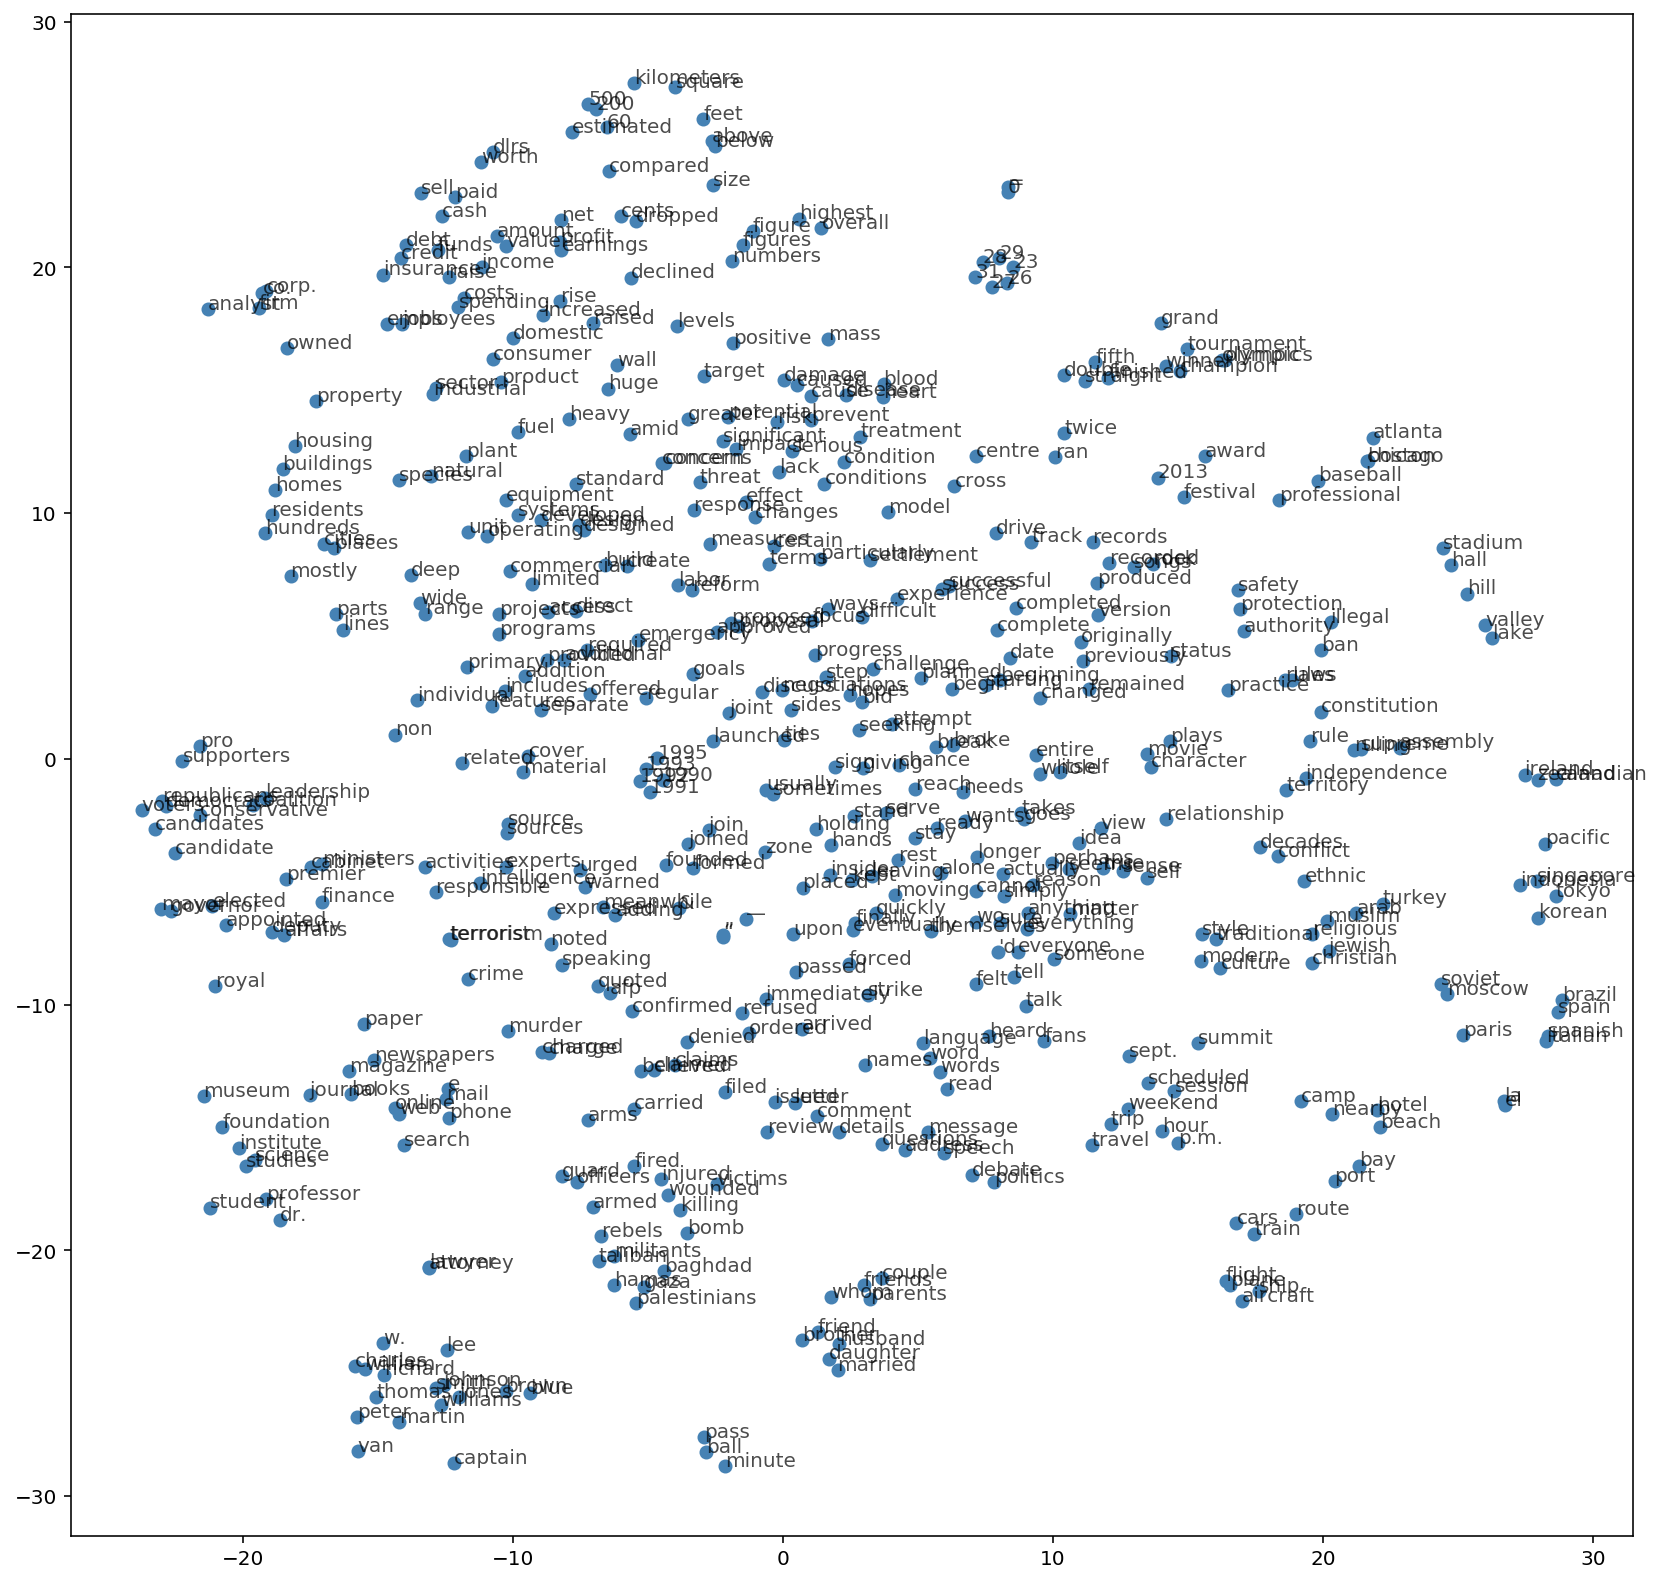

In [0]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.scatter(x=embed_tsne[:,0], y=embed_tsne[:,1], c='steelblue')
# project whole space without colouring
for i, word in enumerate(words[start_ind:end_ind]):
    plt.annotate(word, (embed_tsne[small_word2ind[word], 0], embed_tsne[small_word2ind[word], 1]), alpha=0.7)

### Part4: Meaningful plots (showing up clusters)
- Sort word according to some semantic dimension (you could use the one on sentiment)
- Plot some of them using T-SNE 
- It would help visualization coloring word-points according to their positive/negative orientation 

In [0]:
from operator import itemgetter

scored_words = [(word, determine_coefficient(word, seed_pos, seed_neg)) for word in words[:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)
sample_word_tuples = sorted_words[:50] + sorted_words[-50:] + sorted_words[2500:2550]
sample_words = [t[0] for t in sample_word_tuples]
sample_words_sentiment = [t[1] for t in sample_word_tuples]

small_ind = np.array([word2ind[word] for word in sample_words])
small_word2ind = {word : i for i, word in enumerate(sample_words)}
small_matrix =  matrix[small_ind]

# Project word embeddings to two-dimensions
tsne = TSNE()
embed_tsne = tsne.fit_transform(small_matrix)

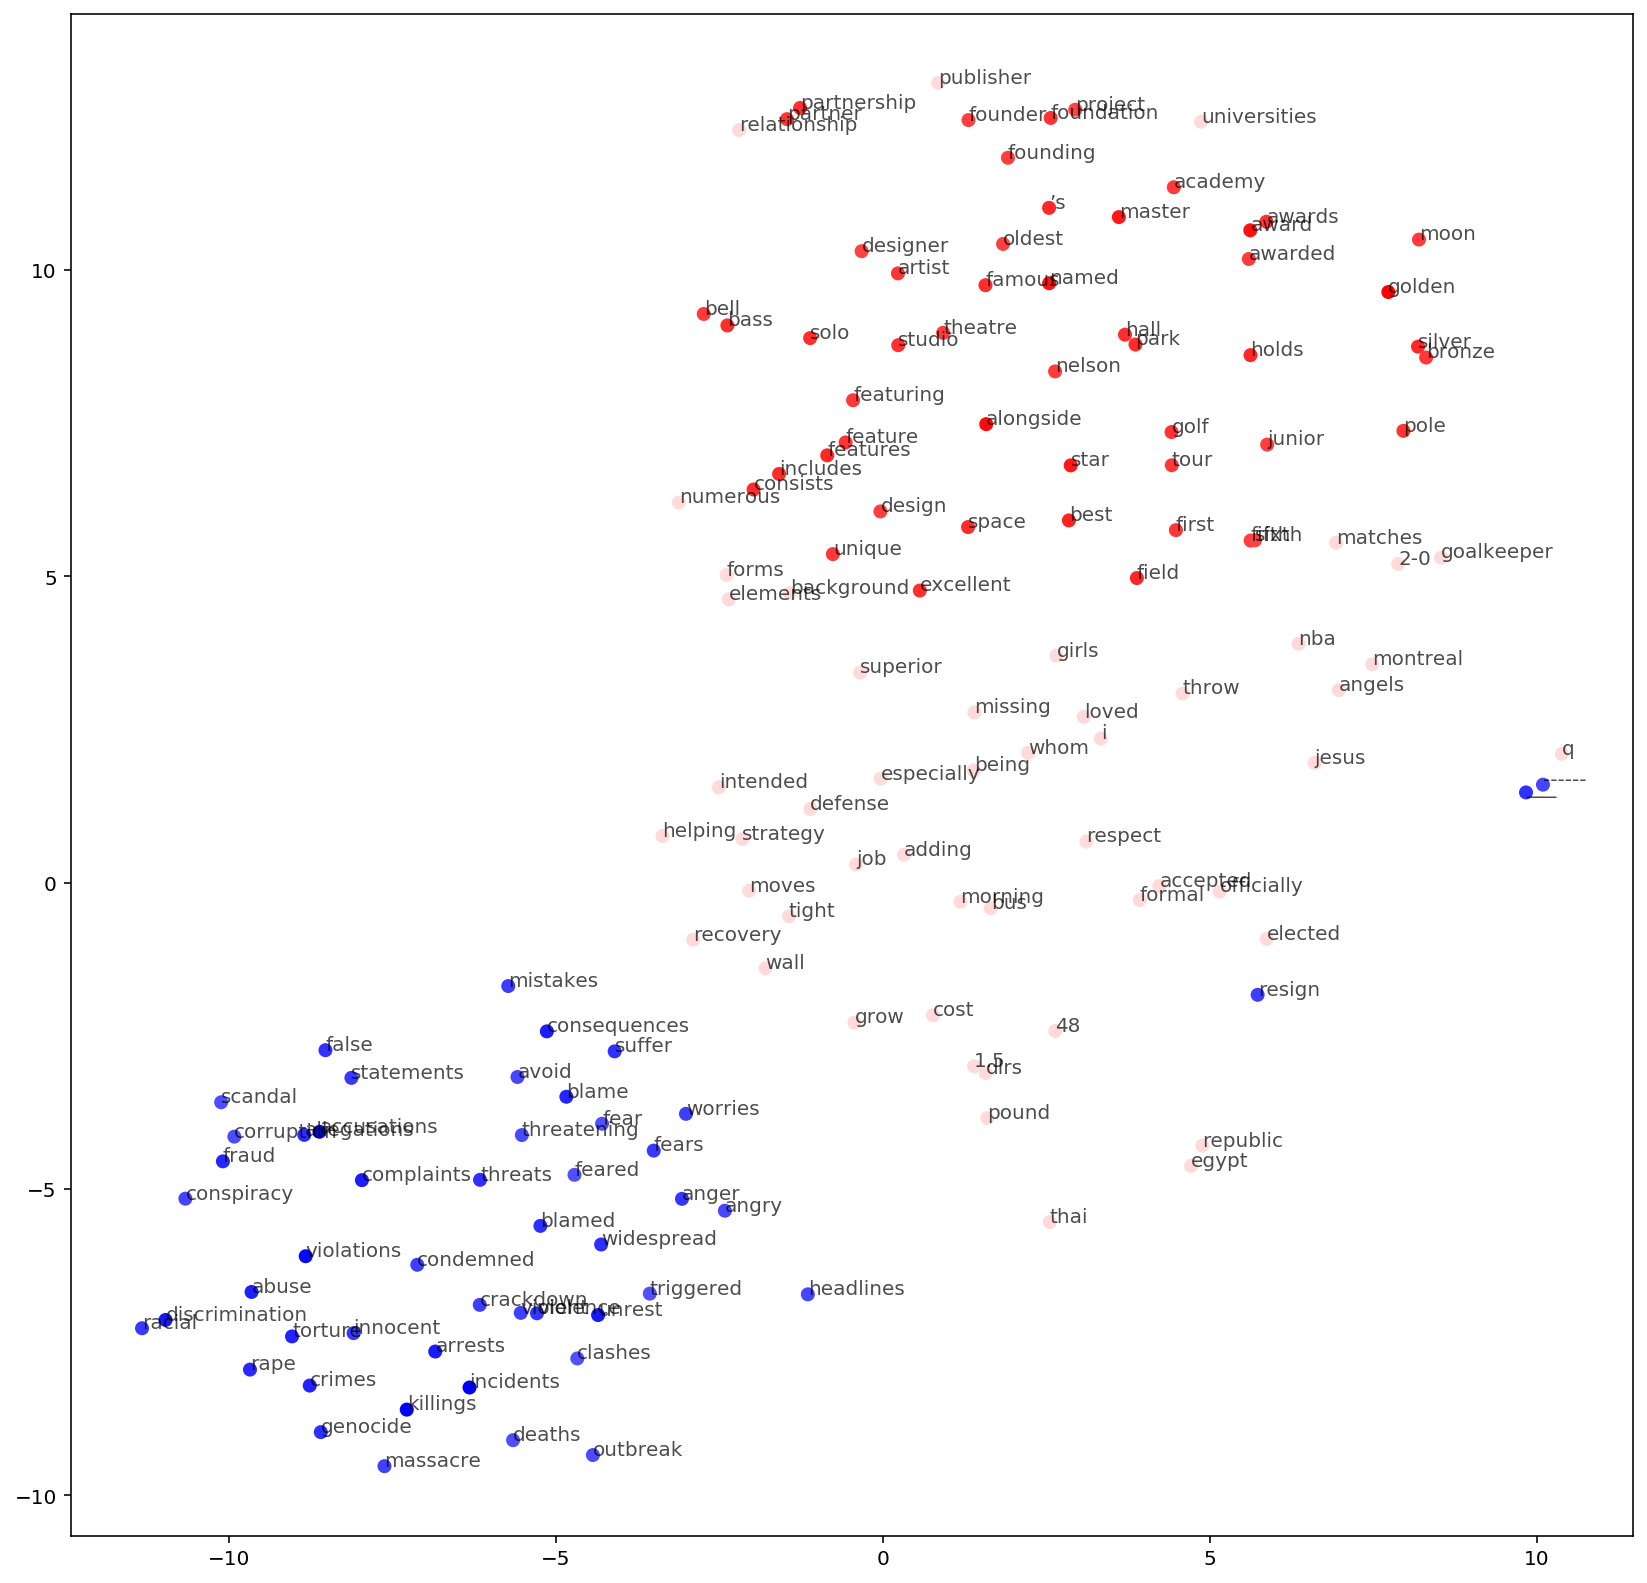

In [0]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.scatter(x=embed_tsne[:,0], y=embed_tsne[:,1], c=sample_words_sentiment, cmap='bwr')
# project whole space mapped with colours
for i, word in enumerate(sample_words):
    plt.annotate(word, (embed_tsne[small_word2ind[word], 0], embed_tsne[small_word2ind[word], 1]), alpha=0.7)

  **ANALYSIS**

As we can see in the previous plot, words in the negative semantic dimension (in blue) are really negative words. Those in pink are kind of neutral, although we have some that are more positive-oriented and should probably be closer to the positive dimension (some examples include "loved" and "grow"). As for the words included in the positive dimension, they are not, in my opinion, as clear-cut as the negative ones. Words such as "featuring" or consists" are neutral, and should not have been added to the positive dimension. This is probably caused by the small data set used here, it was probably the case that these words appeared in the same context as real positive words and they have been, consequently, positioned in the same dimension.

# Team members: 
Edgar Andrés

Mohammed Yassin

Xaidé Caceres

Radostina Peteva

# Consultancy

Mikel Petri

# Atribution: 
Adapted by Oier Lopez de Lacalle and Olatz Perez de Viñaspre, based on the code by Mikel Artetxe at UPV/EHU